In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder

In [118]:
# data ingestion

In [119]:
df=pd.DataFrame(pd.read_csv("C:/ML_AI/loan/loan_acceptance_using_multiple-algorithm/data/raw/train_loan.csv"))

In [120]:
df

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0


In [121]:
df.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [122]:
num = df.select_dtypes(include=["number"])


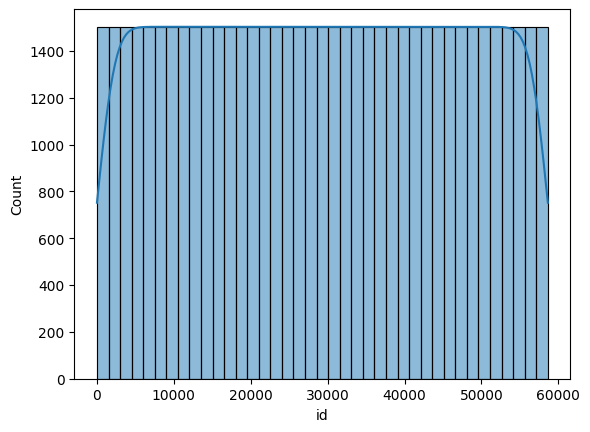

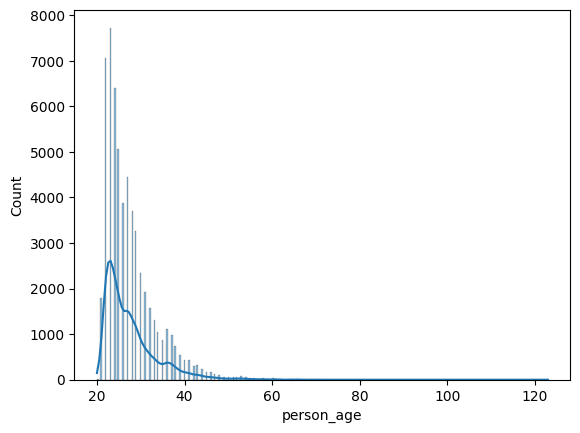

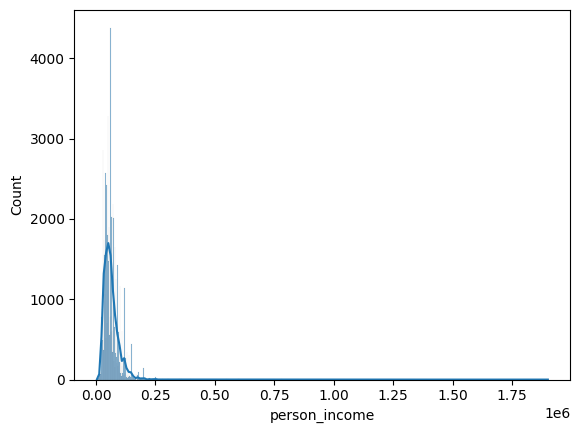

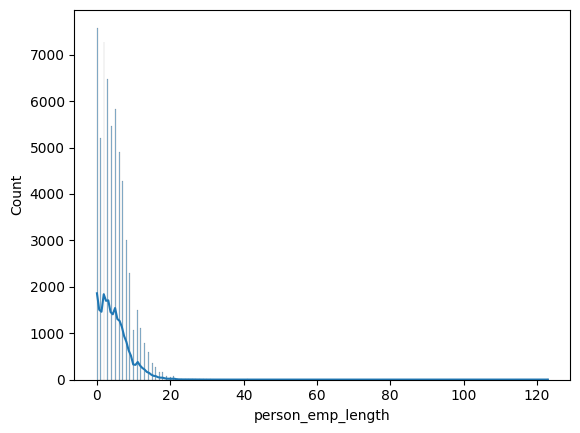

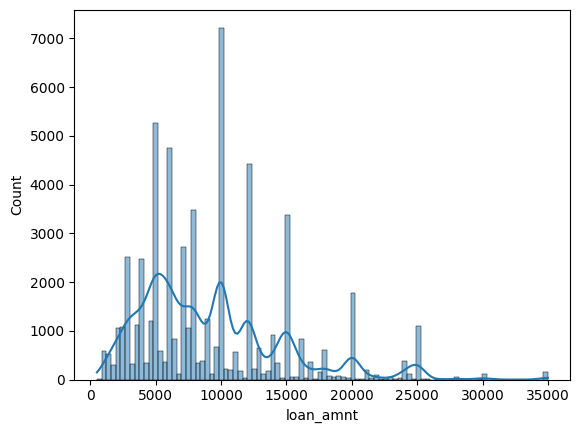

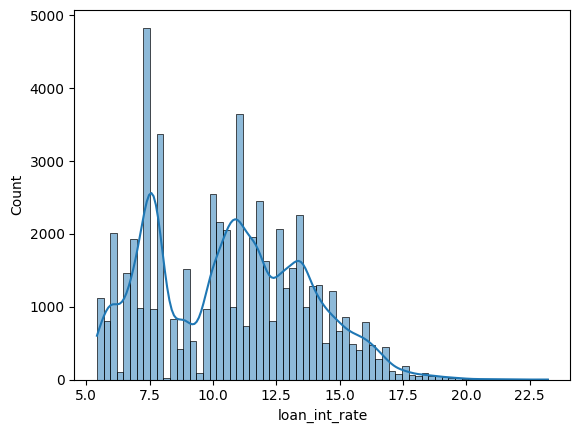

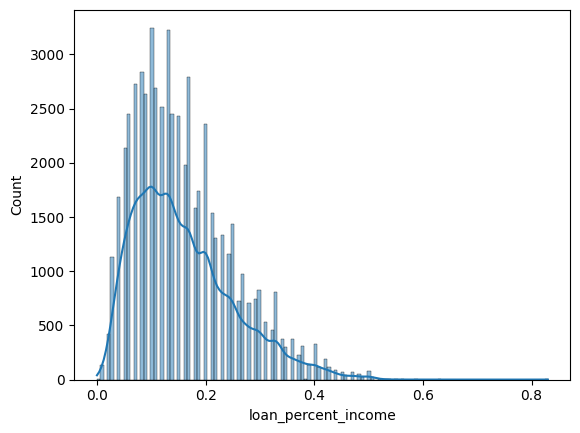

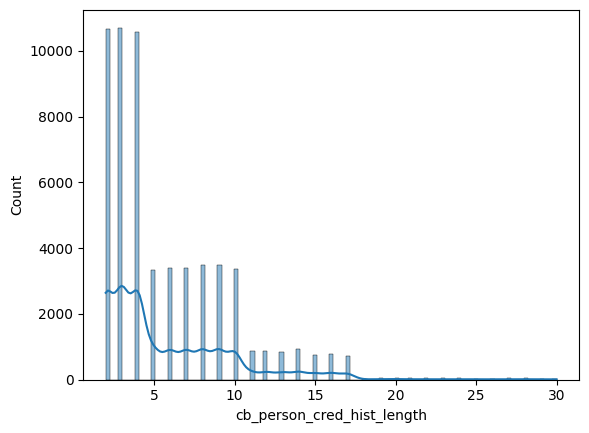

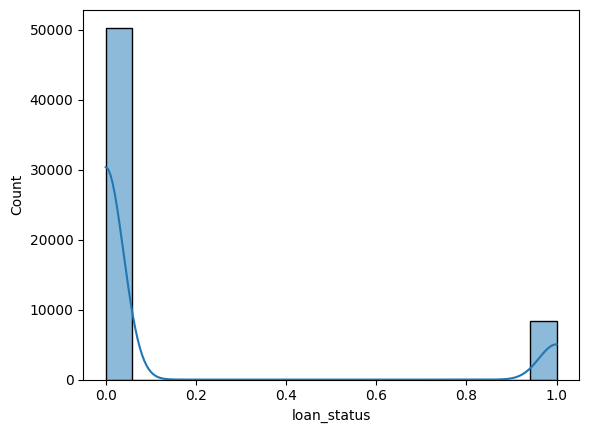

In [123]:
for i in num.columns:
    sns.histplot(data=num,x=i,kde=True)
    show()

In [124]:
X=df.drop(labels=["loan_status","id",'cb_person_cred_hist_length'],axis=1)
Y=df[["loan_status"]]

In [125]:
numeric_col = X.select_dtypes(include=["number"]).columns
categorical_col = X.select_dtypes(exclude=["number"]).columns

In [126]:
# Feature selection Numerical columns

In [127]:
df_temp = pd.concat([X[numeric_col], Y['loan_status']], axis=1)
corr_with_target = df_temp.corr(numeric_only=True)['loan_status'].sort_values(ascending=False)
print(corr_with_target)

loan_status            1.000000
loan_percent_income    0.378280
loan_int_rate          0.338948
loan_amnt              0.144982
person_age            -0.001130
person_emp_length     -0.100428
person_income         -0.169956
Name: loan_status, dtype: float64


In [128]:
corr_matrix = df_temp[numeric_col].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print("Highly correlated features:", to_drop)

Highly correlated features: []


In [129]:
# feature selection for catrgorical fetaures

In [130]:
from scipy.stats import chi2_contingency

In [131]:
results = []
for col in categorical_col:
        table = pd.crosstab(df[col], df["loan_status"])
        chi2, p, dof, ex = chi2_contingency(table)
        results.append({'Feature': col, 'p-value': p})
print(pd.DataFrame(results).sort_values('p-value'))

                     Feature        p-value
0      person_home_ownership   0.000000e+00
2                 loan_grade   0.000000e+00
3  cb_person_default_on_file   0.000000e+00
1                loan_intent  1.949934e-140


In [132]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

for col in categorical_col:
    v = cramers_v(df[col], df['loan_status'])
    print(f"{col}: Cramér’s V = {v:.3f}")

person_home_ownership: Cramér’s V = 0.242
loan_intent: Cramér’s V = 0.106
loan_grade: Cramér’s V = 0.461
cb_person_default_on_file: Cramér’s V = 0.187


In [133]:
num_pipline=make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()

)

In [134]:
cat_pipline=make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
)

In [135]:
cat_pipline_one_hot=make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
)

In [136]:
# splitting the data into train and testing

In [137]:
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.2,random_state=42)

In [138]:
# tranforming data/data processing using pipline

In [139]:
pre_1=ColumnTransformer(
    [
        ("num",num_pipline,numeric_col),
        ("cat",cat_pipline,categorical_col)
    ]
).set_output(transform="pandas")

In [140]:
pre_2=ColumnTransformer(
    [
        ("num",num_pipline,numeric_col),
        ("cat",cat_pipline_one_hot,categorical_col)
    ]
).set_output(transform="pandas")

In [141]:
# Transforming data using ordinal encoding

In [142]:
pre_1.fit(xtrain,ytrain)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [143]:
xtrain_pre_1 = pre_1.transform(xtrain)
xtest_pre_1 = pre_1.transform(xtest)

In [144]:
xtrain_pre_1.index=range(0,46916)
ytrain.index=range(0,46916)

In [145]:
ytrain

,loan_status
0,0
1,0
2,0
3,0
4,0
...,...
46911,0
46912,0
46913,0
46914,0


In [146]:
xtest_pre_1

,num__person_age,num__person_income,num__person_emp_length,num__loan_amnt,num__loan_int_rate,num__loan_percent_income,cat__person_home_ownership,cat__loan_intent,cat__loan_grade,cat__cb_person_default_on_file
4657,-0.753930,-0.625734,-1.182680,-0.988958,-0.882925,-0.751573,3.0,3.0,0.0,0.0
56440,-0.422891,-0.107095,1.077242,-0.755235,-0.688715,-0.860735,0.0,2.0,0.0,0.0
42117,0.735746,0.056277,-1.182680,1.941575,0.608214,1.104183,3.0,3.0,1.0,0.0
10849,-0.919449,-0.885054,-1.182680,-0.755235,-0.030376,0.121724,3.0,0.0,1.0,0.0
39395,-0.091851,-0.107095,-0.931577,-0.395660,0.502879,-0.424086,3.0,3.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
12934,-1.084969,-0.496074,-1.182680,-0.575447,-0.132418,-0.314924,2.0,3.0,1.0,0.0
39660,-0.091851,-0.496074,0.072832,0.143702,0.493004,0.667535,3.0,5.0,1.0,0.0
28657,0.073668,-0.314551,-0.178270,-0.215873,0.397545,-0.096600,3.0,3.0,1.0,0.0
24735,-0.091851,-0.677598,1.579447,-0.395660,-0.010625,0.230886,3.0,3.0,1.0,0.0


In [147]:
xtest_pre_1.index=range(0,11729)
ytest.index=range(0,11729)

In [148]:
xtrain_1=xtrain_pre_1.join(ytrain)

In [149]:
xtest_1=xtest_pre_1.join(ytest)

In [150]:
import os

In [151]:


# Folder to save files
folder_path = r"C:\ML_AI\loan\loan_acceptance_using_multiple-algorithm\data\ordinal_encode"
os.makedirs(folder_path, exist_ok=True)



train_path = os.path.join(folder_path, f"train_processed_data.csv")
test_path = os.path.join(folder_path, f"test_processed_data.csv")

xtrain_1.to_csv(train_path, index=False)
xtest_1.to_csv(test_path, index=False)

print(f"Files saved successfully at: {folder_path}")
print(f"Train file: {train_path}")
print(f"Test file:  {test_path}")


Files saved successfully at: C:\ML_AI\loan\loan_acceptance_using_multiple-algorithm\data\ordinal_encode
Train file: C:\ML_AI\loan\loan_acceptance_using_multiple-algorithm\data\ordinal_encode\train_processed_data.csv
Test file:  C:\ML_AI\loan\loan_acceptance_using_multiple-algorithm\data\ordinal_encode\test_processed_data.csv


In [152]:
# saving one hot encoded 

In [153]:
pre_2.fit(xtrain,ytrain)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [154]:
xtrain_one_hot=pre_2.transform(xtrain)
xtest_one_hot=pre_2.transform(xtest)

In [155]:
xtrain_one_hot.index=range(0,46916)
ytrain.index=range(0,46916)

In [156]:
xtest_one_hot.index=range(0,11729)
ytest.index=range(0,11729)

In [157]:
xtrain_2=xtrain_one_hot.join(ytrain)

In [158]:
xtest_2=xtest_one_hot.join(ytest)

In [159]:



folder_path = r"C:\ML_AI\loan\loan_acceptance_using_multiple-algorithm\data\one_hot_encode"
os.makedirs(folder_path, exist_ok=True)



train_path = os.path.join(folder_path, f"train_processed_data.csv")
test_path = os.path.join(folder_path, f"test_processed_data.csv")

xtrain_2.to_csv(train_path, index=False)
xtest_2.to_csv(test_path, index=False)

print(f"Files saved successfully at: {folder_path}")
print(f"Train file: {train_path}")
print(f"Test file:  {test_path}")

Files saved successfully at: C:\ML_AI\loan\loan_acceptance_using_multiple-algorithm\data\one_hot_encode
Train file: C:\ML_AI\loan\loan_acceptance_using_multiple-algorithm\data\one_hot_encode\train_processed_data.csv
Test file:  C:\ML_AI\loan\loan_acceptance_using_multiple-algorithm\data\one_hot_encode\test_processed_data.csv


In [160]:
df[["loan_status"]].value_counts()

loan_status
0              50295
1               8350
Name: count, dtype: int64

In [161]:
import joblib

In [162]:
joblib.dump(pre_2, "C:/ML_AI/loan/loan_acceptance_using_multiple-algorithm/data/artifacts/data_processor/preprocessor1.pkl")

print("✅ Preprocessor saved successfully!")

✅ Preprocessor saved successfully!


In [163]:
joblib.dump(pre_1, "C:/ML_AI/loan/loan_acceptance_using_multiple-algorithm/data/artifacts/data_processor/preprocessor2.pkl")

print("✅ Preprocessor saved successfully!")

✅ Preprocessor saved successfully!
